# Multiomics modeling

Let's look at the paper *"Multiomics modeling of the immunome, transcriptome, microbiome, proteome and metabolome adaptations during human pregnancy"* by **Ghaemi et al. 2019** (`task1_multiomics_ghaemi2019multiomics.pdf`).
The idea is to use different modalities (measurements collected from the immune system, microbiome, etc.) to characterize biological changes during pregnancy. 
This includes whether we can predict the gestational age of a mother solely based on the collected biomarkers.

**Note**: There is no need to get accquainted with multiomics modeling, at least for this exercise. In the end, this is just a regular data science task :) 

## Load the data

Load the data from `multiomics_data.pickle` using `pickle`. You will get a [pandas](https://pandas.pydata.org/docs/user_guide/10min.html) DataFrame containing preprocessed data from the paper (the original data from their paper is a bit messy). The data contains several meta attributes as well as the different modalities.

Meta attributes include:

* `Sex`: sex of the baby
* `timepoint`: 1-3 correspond to the three trimesters, 4 corresponds to postpartum
* `gestational_age`: time of sampling

Modalites are:
    
* `cellfree_rna`
* `metabolomics`
* `microbiome`
* `plasma_luminex`
* `serum_luminex`
* `immune_system`
* `plasma_somalogic`

For more details please see the paper.

In [1]:
# code for loading the data

import numpy as np
import pickle

with open("multiomics.pickle", "rb") as file:
    data_multiomics = pickle.load(file)
    
data_multiomics.head(5)

Training/Validation Gates ID       MRN Study Subject ID Number     Sex  \
                                                                           
0                   T  PTLG002  16661779                   10565    Male   
1                   T  PTLG002  16661779                   10565    Male   
2                   T  PTLG002  16661779                   10565    Male   
3                   T  PTLG002  16661779                   10565    Male   
4                   T  PTLG004  23587868                   10603  Female   

  sex_bin timepoint gestational_age cellfree_rna                ...  \
                                       0_C2orf76      1_ACTL10  ...   
0       1         1              11     0.312437 -1.892930e-16  ...   
1       1         2              18     0.312437 -1.892930e-16  ...   
2       1         3              32     0.312437 -1.892930e-16  ...   
3       1         4              45     0.312437 -1.892930e-16  ...   
4       0         1              11     5.204209  1.734736e+00  ...   

  plasma_somalogic                                                             \
       1290_UBE2G2 1291_TAGLN2 1292_ATP5O 1293_POMC 1294_CRYZL1 1295_SERPINF1   
0           4804.4      2233.0     3610.9     715.8       151.4       37885.8   
1           4086.0      2160.5     2260.4     825.2       161.0       41821.5   
2           4328.0      1818.4     2445.2    1241.8       194.6       45526.1   
3           3442.4      2661.4     3879.2     703.6       153.7       36862.5   
4           4261.9      1804.6     1470.6     526.8       163.0       38938.3   

                                              
  1296_CTSF 1297_FTCD 1298_USP25 1299_PLXNB2  
0    1479.1    3261.8      561.3      3227.0  
1    1465.1    1839.8      597.8      3366.0  
2    1428.3    3057.2      625.7      8703.7  
3    1063.6    7339.7      593.2      2918.9  
4    1170.1    1036.8      552.8      3457.1  

[5 rows x 61274 columns]

Nishan: Just to get an estimate of the feature density:

In [2]:
import pandas as pd

# display the column names and their respective counts
data_multiomics.columns.get_level_values(0).value_counts()

cellfree_rna               37275
microbiome                 18548
metabolomics                3485
plasma_somalogic            1300
immune_system                534
plasma_luminex                62
serum_luminex                 62
Training/Validation            1
Gates ID                       1
MRN                            1
Study Subject ID Number        1
Sex                            1
sex_bin                        1
timepoint                      1
gestational_age                1
dtype: int64

In [3]:
# unique values in the column "Sex"
print("Categorical entries in sex: ", data_multiomics["Sex"].unique())
# unique values in the column "timepoint"
print("Categorical entries in timepoint: ", data_multiomics["timepoint"].unique())
# unique values in the column "gestational_age" sorted in ascending order
print("Categorical entries in the gestational age: ", np.sort(data_multiomics["gestational_age"].unique()), " (total count: ", len(data_multiomics["gestational_age"].unique()), ")")


Categorical entries in sex:  ['Male' 'Female']
Categorical entries in timepoint:  [1 2 3 4]
Categorical entries in the gestational age:  [ 8 10 11 12 15 16 17 18 19 24 25 26 27 28 31 32 42 43 44 45 46 47 48]  (total count:  23 )


Nishan: Additionally, looking at the nature of the target variables, I'm going to assume that even though this could be interpreted as a classification task, it's a regression task since gestational age doesn't seem like a category. I could convert it into categorical values with an upper and lower bound in which case it'd make sense. However, I'm just going to follow the regression model examples from the paper.

In [4]:
# look at the immune system
data_multiomics["immune_system"].head(5)

,0_Bcells,1_CD16+CD56-NKcells,2_CD4+Tcells_mem,3_CD4+Tcells_naive,4_CD4+Tcells,5_CD45RA+Tregs,6_CD45RA-Tregs,7_CD56+CD16-NKcells,8_CD7+NKcells,9_CD8+Tcells_mem,...,524_M-MDSC_STAT5_Unstim,525_mDCs_STAT5_Unstim,526_ncMCs_STAT5_Unstim,527_pDCs_STAT5_Unstim,528_Tbet+CD4+Tcells_mem_STAT5_Unstim,529_Tbet+CD4+Tcells_naive_STAT5_Unstim,530_Tbet+CD8+Tcells_mem_STAT5_Unstim,531_Tbet+CD8+Tcells_naive_STAT5_Unstim,532_TCRgd+Tcells_STAT5_Unstim,533_Tregs_STAT5_Unstim
0,0.053164,0.054978,0.297875,0.136289,0.445832,0.002570,0.013848,0.007052,0.070836,0.118884,...,0.998954,0.953637,1.082629,0.808610,0.504269,0.757424,0.462045,0.454665,0.443859,0.529431
1,0.052857,0.069794,0.279917,0.140350,0.430839,0.002470,0.010923,0.004759,0.080245,0.127831,...,0.930847,0.822618,0.931126,0.728738,0.613059,0.852393,0.506981,0.474408,0.491691,0.574133
2,0.053202,0.050829,0.277997,0.187659,0.479078,0.003473,0.013359,0.005302,0.063781,0.104513,...,1.077824,0.970954,1.011011,0.749277,0.752882,0.813249,0.560379,0.481862,0.505706,0.640245
3,0.049906,0.090496,0.266336,0.156263,0.432904,0.003071,0.014459,0.004318,0.101386,0.115243,...,0.976888,0.918164,1.028114,0.790166,0.505349,0.648406,0.464522,0.445444,0.438285,0.573058
4,0.103067,0.004128,0.162746,0.103950,0.270840,0.003198,0.007988,0.007153,0.090763,0.057064,...,0.890405,0.800468,1.067789,0.563615,0.464563,1.004497,0.378557,0.423530,0.332368,0.447904


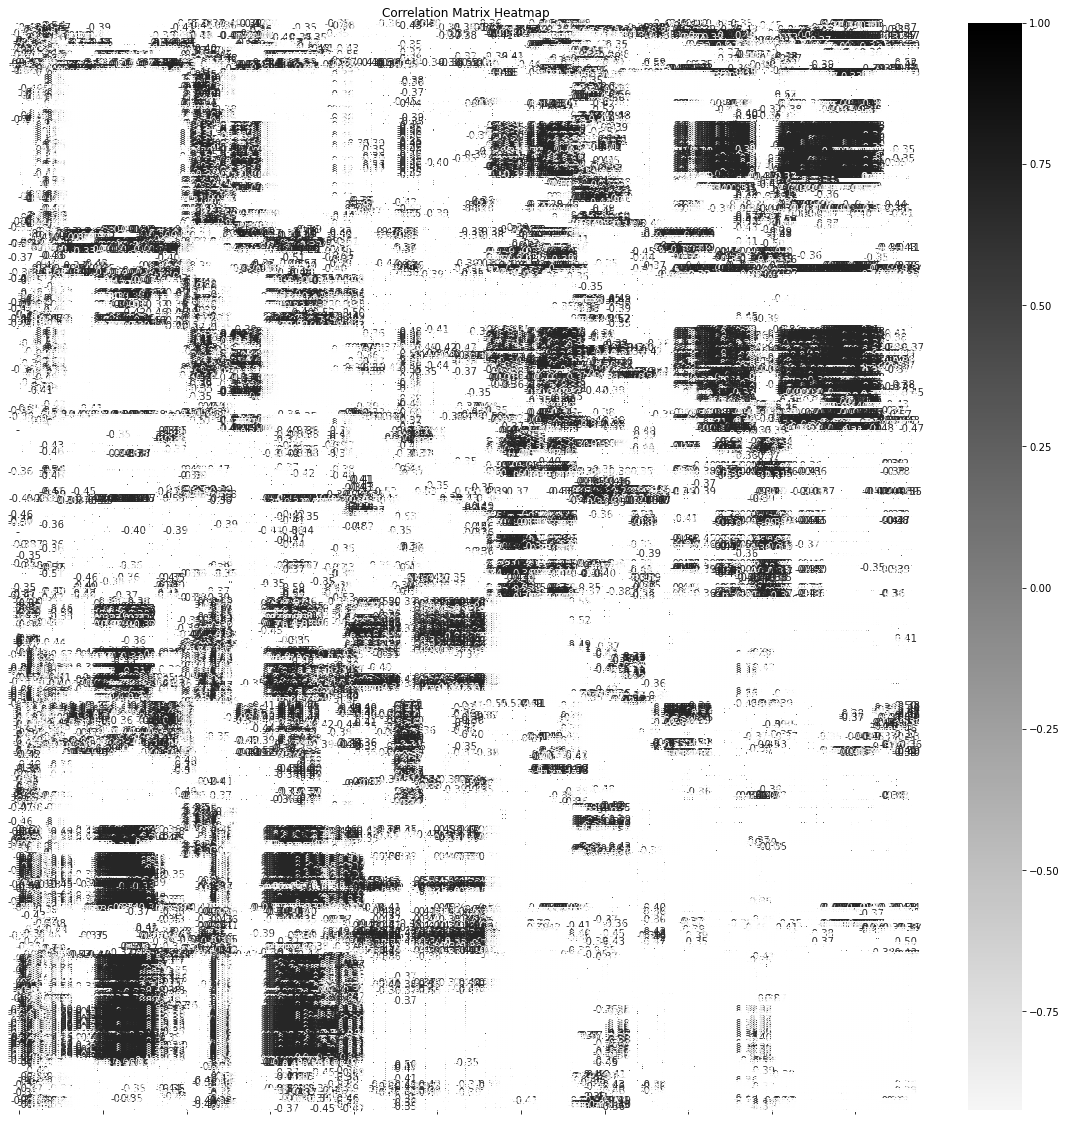

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

# using the immune_system features as features
features = data_multiomics["immune_system"]

# Compute the correlation matrix
correlation_matrix = features.corr()

# Generate a heatmap using Seaborn
plt.figure(figsize=(20, 20))
sns.heatmap(correlation_matrix, cmap='binary', center=0,
            annot=True, fmt=".2f", linewidths=0.5,
            mask=correlation_matrix.abs() < 0.3)  # Set threshold for weak correlation
plt.title("Correlation Matrix Heatmap")
plt.xticks(np.arange(0, len(features.columns), 50), rotation=0)
plt.yticks(np.arange(0, len(features.columns), 50))
plt.show()

Nishan: The figure isn't super intuitive or great in terms of visualization, however, I think the following estimate holds:

    - The sparsely distributed black dots, i.e. the white empty space suggest that there is little to no linear relationship between those variables.

    - On the other hand, the black dots and the dense rectangular clusters of black dots indicate a higher correlation between the variables within those rectangles. This suggests that those variables are more likely to exhibit a linear relationship. Similarly, the leading diagonal is also distinctly present showcasing the self-relationship between the variables. 

So it seems like the data has a mix of linear and non-linearly related variables. Not sure what model is best suited for this. Taking cues from the paper, along with a mix of models from sklearn, I'll create some models to find the one which performs best. Additionally, dimentsionality reduction might be useful.

## Tasks

### Your experience

Before we start, please briefly describe your experience in data science and machine learning (5 sentences).

Nishan: During my master's program, I studied a bit of data science in the Statistical Analysis course at Trinity College Dublin, where I conducted an analysis on myocardial infarctions and to predict the time of occurrence of complications. I also studied information visualization and visual analytics at the University of Stuttgart, where I gained experience in different data visualization techniques and analytical work.

Additionally, in both my bachelor's and master's studies, I engaged in coursework, labs, and seminars focused on machine learning and deep learning, with a particular emphasis on time-series data. While my primary experience lies in working with text and images, I have also ventured into analyzing eye tracking data and video data for some projects. Additionally, I picked up on working with geometric deep learning while working on my master's thesis.

### Gestational Age

1. **Predict `gestational_age`** using the `immune_system` modality using at least two models (e.g., elastic net and support vector machines)

2. **Evaluate** your models using a measure that you think fits best. If it is a different measure than in the paper, please briefly explain why.

3. For your best model, **plot the model predictions** similar to **Figure 2D**.


**Hint:** To train and evaluate models, you can use [scikit-learn](https://scikit-learn.org/stable/tutorial/basic/tutorial.html).

**Figure 2D:**<br/>
<img src="assets/task1_multiomics_fig2d.jpeg">

Nishan: As mentioned above, it seems like the data has a mix of linear and non-linearly related variables. So potentially, Ridge regression, Elastic Nets, Decision Trees, Random Forest, XGBoost, and LightGBM should all work well. Not sure how much linear regression models would perform as that depends on how much the non-linear variables affect the prediction. Additionally, as mentioned before, it might be useful to perform a dimensionality reduction, which is what I do for the neural network implementation.

Taking cues from the paper, along with a mix of models from sklearn, I initialize some models here to find the one which performs best. Note that these can be additionally tuned, and then we can find a good model using grid search or something similar. So it should be kept in mind that the results indicated here might not be the model's best performance as I don't spend too much time tuning them, but rather follow some general strategies.

In [6]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.naive_bayes import GaussianNB

models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(),
    "Lasso Regression": Lasso(),
    "Elastic Net Regression": ElasticNet(),
    "SVR": SVR(),
    "Decision Tree Regression": DecisionTreeRegressor(),
    "Random Forest Regression": RandomForestRegressor(),
    "AdaBoost Regression": AdaBoostRegressor(),
    "K-Nearest Neighbors Regression": KNeighborsRegressor(),
    "Multi-layer Perceptron Regression": MLPRegressor(max_iter=1000),
    "XGBoost Regression": XGBRegressor(),
    "LightGBM Regression": LGBMRegressor(),
    "Gaussian Naive Bayes": GaussianNB()
}

In [7]:
from sklearn.model_selection import LeaveOneOut, GridSearchCV
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
from sklearn.metrics import mean_squared_error
import warnings
from sklearn.exceptions import ConvergenceWarning

# Ignore convergence warnings
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore")

# Create the scaler
scaler = StandardScaler()

# Prepare the data (X: features, y: target)
X = data_multiomics["immune_system"]
y = data_multiomics["gestational_age"]

# Scale the features
X_scaled = scaler.fit_transform(X)

# Define the scoring function for evaluation
def rmse(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    return np.sqrt(mse)

# Performing cross-validation to find the best model
results = []
top_5_features = []
loo = LeaveOneOut()

for model_name, model in tqdm(models.items(), desc="Processing models"):
    # Perform leave-one-out cross-validation
    errors = []
    best_params = []

    for train_index, test_index in loo.split(X_scaled):
        X_train, X_test = X_scaled[train_index], X_scaled[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Perform inner cross-validation for parameter optimization
        grid_search = GridSearchCV(
            model, param_grid={}, scoring='neg_mean_squared_error', cv=5)
        grid_search.fit(X_train, y_train)

        # Get the best model with optimized parameters
        best_model = grid_search.best_estimator_

        # Fit the best model on the training data
        best_model.fit(X_train, y_train)

        # Predict on the test data
        y_pred = best_model.predict(X_test)

        # Calculate RMSE
        error = rmse(y_test, y_pred)
        errors.append(error)

        # Store the best parameters
        best_params.append(grid_search.best_params_)

    # Calculate the mean RMSE across all folds
    mean_rmse = np.mean(errors)
    results.append((model_name, mean_rmse))

    # Fit the model on the full dataset
    model.fit(X_scaled, y)

    # Get feature importance
    if hasattr(model, "coef_"):
        importance = np.abs(model.coef_)
        if len(importance) > 5:
            top_5_indices = np.argsort(importance)[-5:]
            top_5_features.append(
                (model_name, [X.columns[i] for i in top_5_indices]))
        else:
            top_5_features.append((model_name, X.columns.tolist()))

Processing models: 100%|██████████| 13/13 [16:44<00:00, 77.23s/it] 


In [8]:
# Sort the results based on the mean RMSE
results.sort(key=lambda x: x[1])

# Print the results
print("Model\t\t\tRMSE")
for model_name, mean_rmse in results:
    print(f"{model_name:30s}\t\t{mean_rmse:.4f}")

# Print the top 5 most important features for each model
print("\nTop 5 Most Important Features:")
for model_name, features in top_5_features:
    print(f"{model_name}: {features}")

Model			RMSE
Elastic Net Regression        		7.7735
XGBoost Regression            		7.7991
Ridge Regression              		7.8705
Linear Regression             		7.9006
Lasso Regression              		7.9746
AdaBoost Regression           		8.2692
LightGBM Regression           		8.2971
Random Forest Regression      		8.8518
Multi-layer Perceptron Regression		11.2639
Decision Tree Regression      		12.1029
K-Nearest Neighbors Regression		12.4353
SVR                           		13.2117
Gaussian Naive Bayes          		14.4706

Top 5 Most Important Features:
Linear Regression: ['0_Bcells', '18_pDCs', '235_Tregs_IkB_LPS100', '13_Gr', '101_CD16+CD56-NKcells_ERK_IL100']
Ridge Regression: ['0_Bcells', '18_pDCs', '235_Tregs_IkB_LPS100', '13_Gr', '101_CD16+CD56-NKcells_ERK_IL100']
Lasso Regression: ['204_CD7+NKcells_CREB_LPS100', '235_Tregs_IkB_LPS100', '280_M-MDSC_S6_LPS100', '88_Gr_STAT5_IFNa100', '13_Gr']
Elastic Net Regression: ['235_Tregs_IkB_LPS100', '138_Gr_STAT1_IL100', '124_Tregs_ERK_IL1

Nishan: From the above results, we see that Elastic Net, XGBoost, and Ridge Regression perform best (or rather all the top 5 models perform very close to one another). This makes sense as predicted before and in accordance to what the paper suggests. And Linear Regression also works well for now which is interesting.

I also kept the two-layer leave-one-out cross validation strategy, i.e. the leave-one-out strategy along with within each fold, a second CV to optimize the free parameters of each model.

Additionally, I thought that it might be interesting to look at the most important features. But this is just a brief overview as it doesn't highlight the relative importance of the variables using any metric. So probably doesn't make sense if using PCA or some dimensionality reduction method provides better results.

Next, I wanted to check how much the bootstrapping with replacement affects the performances when compared to just the two-layer leave-one-out strategy. That's done in the next block of code.

Processing models: 100%|██████████| 13/13 [16:41<00:00, 77.07s/it] 


Model			RMSE
AdaBoost Regression           		7.6545
Elastic Net Regression        		7.7735
XGBoost Regression            		7.7991
Ridge Regression              		7.8705
Linear Regression             		7.9006
Lasso Regression              		7.9746
LightGBM Regression           		8.2971
Random Forest Regression      		8.7269
Multi-layer Perceptron Regression		11.7568
Decision Tree Regression      		12.3824
K-Nearest Neighbors Regression		12.4353
SVR                           		13.2117
Gaussian Naive Bayes          		14.4706


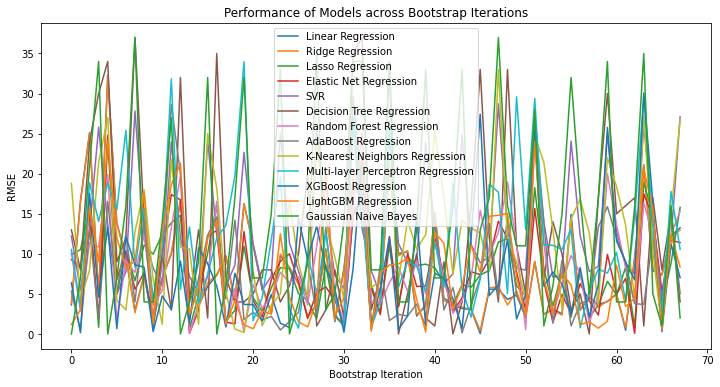


Top 5 Most Important Features:
Linear Regression: ['0_Bcells', '18_pDCs', '235_Tregs_IkB_LPS100', '13_Gr', '101_CD16+CD56-NKcells_ERK_IL100']
Ridge Regression: ['0_Bcells', '18_pDCs', '235_Tregs_IkB_LPS100', '13_Gr', '101_CD16+CD56-NKcells_ERK_IL100']
Lasso Regression: ['204_CD7+NKcells_CREB_LPS100', '235_Tregs_IkB_LPS100', '280_M-MDSC_S6_LPS100', '88_Gr_STAT5_IFNa100', '13_Gr']
Elastic Net Regression: ['235_Tregs_IkB_LPS100', '138_Gr_STAT1_IL100', '124_Tregs_ERK_IL100', '88_Gr_STAT5_IFNa100', '13_Gr']


In [9]:
from sklearn.model_selection import LeaveOneOut, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import warnings
from sklearn.exceptions import ConvergenceWarning


# Ignore convergence warnings
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore")

# Create the scaler
scaler = StandardScaler()

# Prepare the data (X: features, y: target)
X = data_multiomics["immune_system"]
y = data_multiomics["gestational_age"]

# Scale the features
X_scaled = scaler.fit_transform(X)

# Define the scoring function for evaluation
def rmse(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    return np.sqrt(mse)


# Set the bootstrap parameters
n_bootstrap_iterations = 100
m_samples = 57

# Performing bootstrap with piece-wise regression
results = []
top_5_features = []
model_performances = {}

# Initialize LeaveOneOut and GridSearchCV
loo = LeaveOneOut()

for model_name, model in tqdm(models.items(), desc="Processing models"):
    # Initialize the list to store RMSE values for each bootstrap iteration
    rmse_values = []

    # Perform leave-one-out cross-validation
    errors = []
    best_params = []
    for train_index, test_index in loo.split(X_scaled):
        X_train, X_test = X_scaled[train_index], X_scaled[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Perform inner cross-validation for parameter optimization
        grid_search = GridSearchCV(
            model, param_grid={}, scoring='neg_mean_squared_error', cv=5)
        grid_search.fit(X_train, y_train)

        # Get the best model with optimized parameters
        best_model = grid_search.best_estimator_

        # Fit the best model on the training data
        best_model.fit(X_train, y_train)

        # Predict on the test data
        y_pred = best_model.predict(X_test)

        # Calculate RMSE
        error = rmse(y_test, y_pred)
        errors.append(error)

        # Store the best parameters
        best_params.append(grid_search.best_params_)

    # Calculate the mean RMSE across all folds
    mean_rmse = np.mean(errors)
    results.append((model_name, mean_rmse))

    # Fit the model on the full dataset
    model.fit(X_scaled, y)

    # Store the performance for each bootstrap iteration
    model_performances[model_name] = errors

    # Get feature importance
    if hasattr(model, "coef_"):
        importance = np.abs(model.coef_)
        if len(importance) > 5:
            top_5_indices = np.argsort(importance)[-5:]
            top_5_features.append(
                (model_name, [X.columns[i] for i in top_5_indices]))
        else:
            top_5_features.append((model_name, X.columns.tolist()))

# Sort the results based on the mean RMSE
results.sort(key=lambda x: x[1])

# Print the results
print("Model\t\t\tRMSE")
for model_name, mean_rmse in results:
    print(f"{model_name:30s}\t\t{mean_rmse:.4f}")

# Plot the performance of each model across bootstrap iterations
plt.figure(figsize=(12, 6))
for model_name, performances in model_performances.items():
    iterations = range(len(performances))
    plt.plot(iterations[:len(performances)], performances, label=model_name)
plt.xlabel("Bootstrap Iteration")
plt.ylabel("RMSE")
plt.title("Performance of Models across Bootstrap Iterations")
plt.legend()
plt.show()

# Print the top 5 most important features for each model
print("\nTop 5 Most Important Features:")
for model_name, features in top_5_features:
    print(f"{model_name}: {features}")

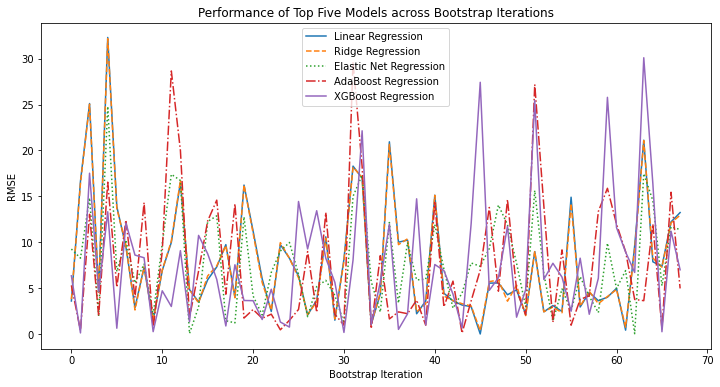

In [10]:
# Get the top five models based on mean RMSE
top_models = results[:5]

# Define line styles for the top five models
line_styles = ['-', '--', '-.', ':', '-']

# Plot the performance of the top five models across bootstrap iterations
plt.figure(figsize=(12, 6))
for i, (model_name, performances) in enumerate(model_performances.items()):
    if model_name in [model[0] for model in top_models]:
        iterations = range(len(performances))
        # Cycle through line styles
        line_style = line_styles[i % len(line_styles)]
        plt.plot(iterations[:len(performances)], performances,
                 label=model_name, linestyle=line_style)

plt.xlabel("Bootstrap Iteration")
plt.ylabel("RMSE")
plt.title("Performance of Top Five Models across Bootstrap Iterations")
plt.legend()
plt.show()

Nishan: I think the fluctuations are because of the randomness introduced by the bootstrap sampling process. Regularization should help improve this. Also, maybe stratified bootstrapping works. I wanted to perform them, but given time constraints, I'm not attempting them for this submission.

Nishan: I think the following is the plot I was supposed to draw. However, since I didn't explicitly tune the models in the bootstrapping case, I simply highlighted all of the used model performances across the gestational age prediction. As expected, the line-charts don't really match the figure I was supposed to replicate. I hope that for the sake of this task, this is adequate.

However, if I was supposed to model all the variables to show the importance of each variable with the best model, then I need to do this again. I'll do that if I have time later.

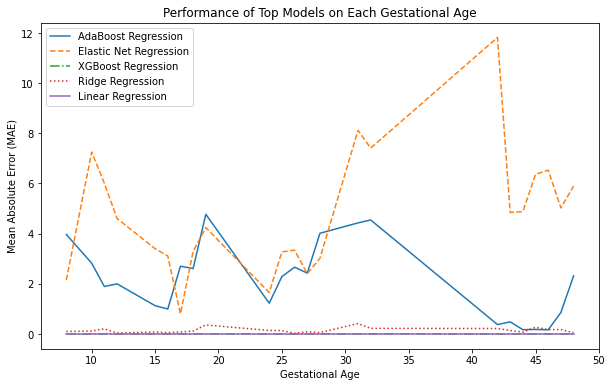

In [12]:
from sklearn.metrics import mean_absolute_error

# Prepare the data (X: features, y: target)
X = data_multiomics["immune_system"]
y = data_multiomics["gestational_age"]

# Scale the features
X_scaled = scaler.fit_transform(X)

# Set the number of top models to consider
n_top_models = 5

# Get the top 5 models based on mean RMSE
top_models = [model_name for model_name, _ in results[:n_top_models]]

# Define line styles for each model
line_styles = ['-', '--', '-.', ':', '-']

# Calculate the performance for the top models on each gestational age
model_performances = {}
for i, model_name in enumerate(top_models):
    model = models[model_name]

    # Fit the model on the scaled features
    model.fit(X_scaled, y)

    # Predict the gestational age
    gestational_ages = []
    performances = []
    for age in range(int(y.min()), int(y.max()) + 1):
        indices = np.where(y == age)[0]

        # Check if samples are available for the current gestational age
        if len(indices) > 0:
            X_age = X_scaled[indices]

            # Predict the gestational age for the current model
            y_pred = model.predict(X_age)

            # Calculate MAE
            mae = mean_absolute_error(np.full(len(X_age), age), y_pred)

            # Append the gestational age and performance to the lists
            gestational_ages.append(age)
            performances.append(mae)

    # Check if all performances are zero
    if all(performances[i] == 0 for i in range(len(performances))):
        continue  # Skip models with zero performance

    # Store the model's performance
    model_performances[model_name] = (gestational_ages, performances)

# Plot the performance of the top models on each gestational age
plt.figure(figsize=(10, 6))
for i, model_name in enumerate(top_models):
    if model_name not in model_performances:
        continue  # Skip models with zero performance

    gestational_ages, performances = model_performances[model_name]
    line_style = line_styles[i % len(line_styles)]  # Cycle through line styles
    plt.plot(gestational_ages, performances,
             label=model_name, linestyle=line_style)

plt.xlabel("Gestational Age")
plt.ylabel("Mean Absolute Error (MAE)")
plt.title("Performance of Top Models on Each Gestational Age")
plt.legend()
plt.show()

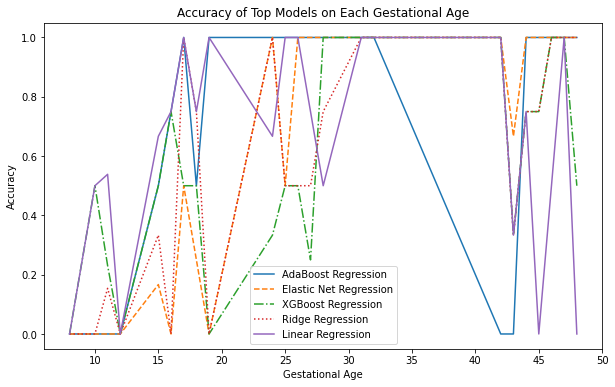

In [13]:
from sklearn.metrics import accuracy_score

# Prepare the data (X: features, y: target)
X = data_multiomics["immune_system"]
y = data_multiomics["gestational_age"]

# Scale the features
X_scaled = scaler.fit_transform(X)

# Set the number of top models to consider
n_top_models = 5

# Get the top 5 models based on mean RMSE
top_models = [model_name for model_name, _ in results[:n_top_models]]

# Define line styles for each model
line_styles = ['-', '--', '-.', ':', '-']

# Calculate the performance for the top models on each gestational age
model_performances = {}
for i, model_name in enumerate(top_models):
    model = models[model_name]

    # Fit the model on the scaled features
    model.fit(X_scaled, y)

    # Predict the gestational age
    gestational_ages = []
    accuracies = []
    for age in range(int(y.min()), int(y.max()) + 1):
        indices = np.where(y == age)[0]

        # Check if samples are available for the current gestational age
        if len(indices) > 0:
            X_age = X_scaled[indices]

            # Convert the prediction problem into classification problem
            y_age = np.full(len(X_age), age)
            y_pred = model.predict(X_age)

            # Convert the continuous values into class labels
            y_age_class = np.where(y_age <= age, 0, 1)
            y_pred_class = np.where(y_pred <= age, 0, 1)

            # Calculate accuracy
            accuracy = accuracy_score(y_age_class, y_pred_class)

            # Append the gestational age and accuracy to the lists
            gestational_ages.append(age)
            accuracies.append(accuracy)

    # Check if all accuracies are zero
    if all(accuracies[i] == 0 for i in range(len(accuracies))):
        continue  # Skip models with zero accuracy

    # Store the model's performance
    model_performances[model_name] = (gestational_ages, accuracies)

# Plot the performance of the top models on each gestational age
plt.figure(figsize=(10, 6))
for i, model_name in enumerate(top_models):
    if model_name not in model_performances:
        continue  # Skip models with zero accuracy

    gestational_ages, accuracies = model_performances[model_name]
    line_style = line_styles[i % len(line_styles)]  # Cycle through line styles
    plt.plot(gestational_ages, accuracies,
             label=model_name, linestyle=line_style)

plt.xlabel("Gestational Age")
plt.ylabel("Accuracy")
plt.title("Accuracy of Top Models on Each Gestational Age")
plt.legend()
plt.show()

Nishan: I tried both MAE and Accuracy to plot the model performances across the different gestational ages.

### Sex of the baby

1. Try using a neural network in Tensorflow or PyTorch to predict the sex of the baby. 
2. Try to optimize the network the best you can (don't spend too much time on this though).

In [14]:
# display the column names and their respective counts
# redundant output since we already saw this output in a previous cell, but nicer to see here too
data_multiomics.columns.get_level_values(0).value_counts()

cellfree_rna               37275
microbiome                 18548
metabolomics                3485
plasma_somalogic            1300
immune_system                534
plasma_luminex                62
serum_luminex                 62
Training/Validation            1
Gates ID                       1
MRN                            1
Study Subject ID Number        1
Sex                            1
sex_bin                        1
timepoint                      1
gestational_age                1
dtype: int64

Time-series modeling didn't make sense. So I'm going to write another multi-layer Perceptron using torch using all the modalities as inputs and the binary sex as output. Also since I'm working with limited computing resources, and it's not really outlined to find the most important variables for the task, I'm going to use PCA to perform a dimensionality reduction in order to reduce training time.

In [15]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Prepare the input and output data
X_cellfree_rna = data_multiomics["cellfree_rna"]
X_microbiome = data_multiomics["microbiome"]
X_metabolomics = data_multiomics["metabolomics"]
X_plasma_somalogic = data_multiomics["plasma_somalogic"]
X_immune_system = data_multiomics["immune_system"]
X_plasma_luminex = data_multiomics["plasma_luminex"]
X_serum_luminex = data_multiomics["serum_luminex"]
y = data_multiomics["Sex"]

# Concatenate the input variables into a joint feature matrix
X = np.hstack((X_cellfree_rna, X_microbiome, X_metabolomics, X_plasma_somalogic,
               X_immune_system, X_plasma_luminex, X_serum_luminex))

# Normalize the data using StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Perform PCA for dimensionality reduction
pca = PCA(n_components=0.95, svd_solver='full')
X_pca = pca.fit_transform(X_scaled)

# Explanation of PCA settings:
# - n_components: Number of components to keep after dimensionality reduction.
#   In this example, we set it to 0.95, indicating that we want to keep enough
#   components to explain 95% of the variance in the data.
# - svd_solver: Algorithm to use for singular value decomposition (SVD).
#   Here, we set it to 'full' to compute the full SVD.

# Now you can use X_pca as the reduced feature matrix for further analysis or modeling.
# Note that the number of columns in X_pca represents the reduced dimensionality of the input variables.

# Print the explained variance ratio
print("Explained variance ratio:", np.sum(pca.explained_variance_ratio_))

# Print the shape of the reduced feature matrix
print("Shape of X_pca:", X_pca.shape)

Explained variance ratio: 0.9537765781485874
Shape of X_pca: (68, 51)


## Tasks

Training:  33%|███▎      | 33/100 [00:00<00:00, 170.76it/s, Epoch Loss=0.0179]


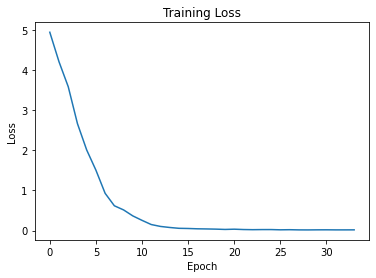

Accuracy: 64.29%


In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import random
import matplotlib.pyplot as plt
from tqdm import tqdm


class ExperimentConfig:
    def __init__(self, input_dim, hidden_dim, output_dim, learning_rate, num_epochs):
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.learning_rate = learning_rate
        self.num_epochs = num_epochs


def run_experiment(config, X_pca, y):
    # Set random seeds for reproducibility and stable results
    random.seed(42)
    np.random.seed(42)
    torch.manual_seed(42)
    torch.cuda.manual_seed(42)
    torch.backends.cudnn.deterministic = True

    # Encode the target variable
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)

    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(
        X_pca, y_encoded, test_size=0.2, random_state=42)

    # Convert data to PyTorch tensors
    X_train_tensor = torch.Tensor(X_train)
    y_train_tensor = torch.Tensor(y_train).long()
    X_test_tensor = torch.Tensor(X_test)
    y_test_tensor = torch.Tensor(y_test).long()

    # Create a PyTorch DataLoader
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

    # Define the MLP model
    class MLP(nn.Module):
        def __init__(self, input_dim, hidden_dim, output_dim):
            super(MLP, self).__init__()
            self.fc1 = nn.Linear(input_dim, hidden_dim)
            self.relu = nn.ReLU()
            self.fc2 = nn.Linear(hidden_dim, output_dim)

        def forward(self, x):
            x = self.fc1(x)
            x = self.relu(x)
            x = self.fc2(x)
            return x

    # Create an instance of the MLP model
    model = MLP(config.input_dim, config.hidden_dim, config.output_dim)

    # Define the loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=config.learning_rate)

    # Train the model with early stopping
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    best_loss = float('inf')
    patience = 5
    counter = 0

    epoch_losses = []

    pbar = tqdm(total=config.num_epochs, desc="Training")
    for epoch in range(config.num_epochs):
        model.train()
        running_loss = 0.0

        for inputs, labels in train_dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        epoch_loss = running_loss / len(train_dataloader)
        epoch_losses.append(epoch_loss)

        if epoch_loss < best_loss:
            best_loss = epoch_loss
            counter = 0
        else:
            counter += 1
            if counter >= patience:
                break

        pbar.set_postfix({"Epoch Loss": epoch_loss})
        pbar.update(1)

    pbar.close()

    # Plot the training loss
    plt.plot(epoch_losses)
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()

    # Evaluate the model on the test set
    model.eval()
    with torch.no_grad():
        X_test_tensor = X_test_tensor.to(device)
        y_test_tensor = y_test_tensor.to(device)
        outputs = model(X_test_tensor)
        _, predicted = torch.max(outputs, 1)
        accuracy = (predicted == y_test_tensor).sum().item() / \
            len(y_test_tensor)
        print("Accuracy: {:.2%}".format(accuracy))


# Define the experiment configuration
experiment_config = ExperimentConfig(
    input_dim=X_pca.shape[1],
    hidden_dim=32,
    output_dim=2,  # Assuming binary classification
    learning_rate=0.001,
    num_epochs=100
)

# Run the experiment
run_experiment(experiment_config, X_pca, y)

Training:  16%|█▋        | 165/1000 [00:01<00:05, 154.02it/s, Epoch Loss=0.0637]


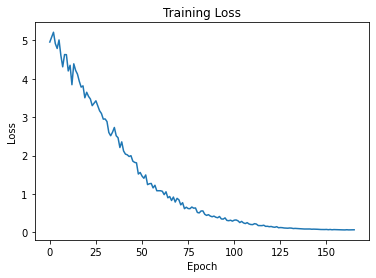

Accuracy: 64.29%


In [17]:
# addtional experiments
experiment_config = ExperimentConfig(
    input_dim=X_pca.shape[1],
    hidden_dim=32,
    output_dim=2,  # Assuming binary classification
    learning_rate=0.0001,
    num_epochs=1000
)

# Run the experiment
run_experiment(experiment_config, X_pca, y)

Training:  51%|█████     | 51/100 [00:00<00:00, 159.85it/s, Epoch Loss=0.00455]


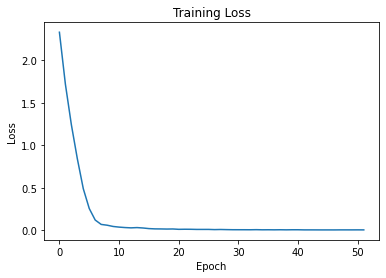

Accuracy: 50.00%


In [18]:
# additional experiments
experiment_config = ExperimentConfig(
    input_dim=X_pca.shape[1],
    hidden_dim=64,
    output_dim=2,  # Assuming binary classification
    learning_rate=0.001,
    num_epochs=100
)

# Run the experiment
run_experiment(experiment_config, X_pca, y)

Nishan: I tried a few experiments with increasing the hidden dimension more. But the performance degraded. Additionally, the accuracy of the model also took a hit when reducing the hidden dim size as compared to the base 32. However, I'd want to use CNN'S or something else to write the "best" model along with using all of the modalities.

### Feedback

Were the tasks above difficult, easy, or a mixture? In both cases, briefly describe why.

Nishan: The tasks were very interesting. In terms of execution and analytical comprehension, I found them moderately challenging since I haven't worked with small datasets that much. However, even though I haven't worked with this kind of data or analysis a lot, I find these problems very interesting and it was really nice playing around with different parameters and models to address the task and replicate the work done in the paper.